In [1]:
import warnings, os
import numpy as np
import pandas as pd
from nbeats_keras.model import NBeatsNet as NBeatsKeras
warnings.filterwarnings(action='ignore', message='Setting attributes')
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
config = tf.compat.v1.ConfigProto() # Another Version: config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [3]:
# plot utils.
def plot_scatter(*args, **kwargs):
    plt.plot(*args, **kwargs)
    plt.scatter(*args, **kwargs)


# simple batcher.
def data_generator(x, y, size):
    assert len(x) == len(y)
    batches = []
    for ii in range(0, len(x), size):
        batches.append((x[ii:ii + size], y[ii:ii + size]))
    for batch in batches:
        yield batch

        
def MinMaxScaler(data):
  """Min Max normalizer.
  
  Args:
    - data: original data
  
  Returns:
    - norm_data: normalized data
  """
  numerator = data - np.min(data, 0)
  denominator = np.max(data, 0) - np.min(data, 0)
  norm_data = numerator / (denominator + 1e-7)
  return norm_data
        
# to load real data        
def real_data_loading (data_name, seq_len):
  """Load and preprocess real-world datasets.
  
  Args:
    - data_name: stock or energy
    - seq_len: sequence length
    
  Returns:
    - data: preprocessed data.
  """  

  assert data_name in ['stock','energy']
  
  if data_name == 'stock':
    ori_data = np.loadtxt('/data/home/stufs1/zuwang/dg21/TimeGAN/data/stock_data.csv', delimiter = ",",skiprows = 1)
  elif data_name == 'energy':
    ori_data = np.loadtxt('/data/home/stufs1/zuwang/dg21/TimeGAN/data/energy_data.csv', delimiter = ",",skiprows = 1)
        
  # Flip the data to make chronological data
  ori_data = ori_data[::-1]
  # Normalize the data
  ori_data = MinMaxScaler(ori_data)
    
  # Preprocess the dataset
  temp_data = []    
  # Cut data by sequence length
  for i in range(0, len(ori_data) - seq_len):
    _x = ori_data[i:i + seq_len]
    temp_data.append(_x)
        
  # Mix the datasets (to make it similar to i.i.d)
  idx = np.random.permutation(len(temp_data))    
  data = []
  for i in range(len(temp_data)):
    data.append(temp_data[idx[i]])
    
  return data

In [4]:
# load the generated data -- TimeGAN
src_path = "/data/home/stufs1/zuwang/dg21/TimeGAN/"
file_name = "stock_data.npy"

syn_data = np.load(os.path.join(src_path, file_name))
print("synthetic data shape:", syn_data.shape) # (no, seq_len, dim)

synthetic data shape: (3661, 24, 6)


In [5]:
# load the real data -- TimeGAN
data_name = "stock"
seq_len = 24
ori_data = real_data_loading(data_name, seq_len) # 
ori_data = np.asarray(ori_data)
print("real data shape:", ori_data.shape) # (no, seq_len, dim)

real data shape: (3661, 24, 6)


In [6]:
len(syn_data[0])

24

In [7]:
num_samples, time_steps, input_dim, output_dim = 3661, 24, 6, 6
backend = NBeatsKeras(
        input_dim=input_dim,
        backcast_length=15, forecast_length=5,
        stack_types=(NBeatsKeras.GENERIC_BLOCK, NBeatsKeras.GENERIC_BLOCK),
        nb_blocks_per_stack=2, thetas_dim=(4, 4), share_weights_in_stack=True,
        hidden_layer_units=64
    )

# Definition of the objective function and the optimizer.
backend.compile(loss='mae', optimizer='adam')

forecast_length = 5
backcast_length = 3*forecast_length

#### Stock-TimeGAN
# x: data backcast/y: forecast generation.

x_train, y_train = [], []
for i in range(len(syn_data)):
    for epoch in range(backcast_length, len(syn_data[i]) - forecast_length):
        x_train.append(syn_data[i][epoch - backcast_length:epoch])
        y_train.append(syn_data[i][epoch:epoch + forecast_length])

x_test, y_test = [], []
for i in range(len(ori_data)):
    for epoch in range(backcast_length, len(ori_data[i]) - forecast_length):
        x_test.append(ori_data[i][epoch - backcast_length:epoch])
        y_test.append(ori_data[i][epoch:epoch + forecast_length])

# normalization.
norm_constant = np.max(x_train)
x_train, y_train = x_train / norm_constant, y_train / norm_constant
x_test, y_test = x_test / norm_constant, y_test / norm_constant
test_size = len(x_test)
print("test_size is:", test_size)

test_size is: 14644


In [8]:
# check the model data shape
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((14644, 15, 6), (14644, 5, 6), (14644, 15, 6), (14644, 5, 6))

In [9]:
# Train the model.
print('Training...')
backend.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=1000, batch_size=128)

# Save the model for later.
backend.save('n_beats_model.h5')

# Predict on the testing set (forecast).
predictions_forecast = backend.predict(x_test)
print("the prediction_forecast shape is:", predictions_forecast.shape) #shape: (30, 5, 1)
#np.testing.assert_equal(predictions_forecast.shape, (test_size, backend.forecast_length, output_dim))

# Predict on the testing set (backcast).
predictions_backcast = backend.predict(x_test, return_backcast=True)
print("the prediction_backcast shape is:", predictions_backcast.shape) #shape: (30, 15, 1)
#np.testing.assert_equal(predictions_backcast.shape, (test_size, backend.backcast_length, output_dim))

# Load the model.
model_2 = NBeatsKeras.load('n_beats_model.h5')
predicts = model_2.predict(x_test)
print("the reloaded prediction_shape is:", predicts.shape) #shape: (30, 5, 1)
#np.testing.assert_almost_equal(predictions_forecast, model_2.predict(x_test))

Training...
Epoch 1/1000
115/115 [==============================] - 23s 44ms/step - loss: 0.2884 - val_loss: 0.2504
Epoch 2/1000
115/115 [==============================] - 1s 10ms/step - loss: 0.1532 - val_loss: 0.2737
Epoch 3/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1492 - val_loss: 0.2754
Epoch 4/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1493 - val_loss: 0.2797
Epoch 5/1000
115/115 [==============================] - 1s 10ms/step - loss: 0.1460 - val_loss: 0.2710
Epoch 6/1000
115/115 [==============================] - 1s 10ms/step - loss: 0.1495 - val_loss: 0.2779
Epoch 7/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1457 - val_loss: 0.3022
Epoch 8/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1470 - val_loss: 0.2770
Epoch 9/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1424 - val_loss: 0.2758
Epoch 10/1000
115/115 [==============================] - 1s 9ms/s

115/115 [==============================] - 1s 9ms/step - loss: 0.1361 - val_loss: 0.2973
Epoch 81/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1373 - val_loss: 0.3021
Epoch 82/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1378 - val_loss: 0.2968
Epoch 83/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1405 - val_loss: 0.2886
Epoch 84/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1367 - val_loss: 0.2805
Epoch 85/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1365 - val_loss: 0.2809
Epoch 86/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1385 - val_loss: 0.2836
Epoch 87/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1379 - val_loss: 0.2797
Epoch 88/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1369 - val_loss: 0.2929
Epoch 89/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1557 - v

115/115 [==============================] - 1s 9ms/step - loss: 0.1383 - val_loss: 0.2854
Epoch 160/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1331 - val_loss: 0.2825
Epoch 161/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1346 - val_loss: 0.2867
Epoch 162/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1363 - val_loss: 0.2849
Epoch 163/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1353 - val_loss: 0.2821
Epoch 164/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1378 - val_loss: 0.2843
Epoch 165/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1366 - val_loss: 0.2912
Epoch 166/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1381 - val_loss: 0.2831
Epoch 167/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1355 - val_loss: 0.2851
Epoch 168/1000
115/115 [==============================] - 1s 9ms/step - loss: 0

Epoch 238/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1383 - val_loss: 0.2891
Epoch 239/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1363 - val_loss: 0.2898
Epoch 240/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1341 - val_loss: 0.2925
Epoch 241/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1354 - val_loss: 0.2822
Epoch 242/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1345 - val_loss: 0.2858
Epoch 243/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1348 - val_loss: 0.2907
Epoch 244/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1332 - val_loss: 0.2902
Epoch 245/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1358 - val_loss: 0.2813
Epoch 246/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1333 - val_loss: 0.2910
Epoch 247/1000
115/115 [==============================] - 1s 9ms

115/115 [==============================] - 1s 9ms/step - loss: 0.1359 - val_loss: 0.2584
Epoch 317/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1438 - val_loss: 0.2860
Epoch 318/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1376 - val_loss: 0.2975
Epoch 319/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1349 - val_loss: 0.2960
Epoch 320/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1336 - val_loss: 0.3014
Epoch 321/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1364 - val_loss: 0.2968
Epoch 322/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1323 - val_loss: 0.2517
Epoch 323/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1432 - val_loss: 0.2958
Epoch 324/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1351 - val_loss: 0.2985
Epoch 325/1000
115/115 [==============================] - 1s 9ms/step - loss: 0

Epoch 395/1000
115/115 [==============================] - 1s 10ms/step - loss: 0.1359 - val_loss: 0.2831
Epoch 396/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1424 - val_loss: 0.2817
Epoch 397/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1454 - val_loss: 0.2782
Epoch 398/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1426 - val_loss: 0.2774
Epoch 399/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1385 - val_loss: 0.2793
Epoch 400/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1359 - val_loss: 0.2850
Epoch 401/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1363 - val_loss: 0.2776
Epoch 402/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1360 - val_loss: 0.2844
Epoch 403/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1399 - val_loss: 0.2783
Epoch 404/1000
115/115 [==============================] - 1s 9m

115/115 [==============================] - 1s 9ms/step - loss: 0.1368 - val_loss: 0.2768
Epoch 474/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1385 - val_loss: 0.2763
Epoch 475/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1338 - val_loss: 0.2819
Epoch 476/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1355 - val_loss: 0.2843
Epoch 477/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1356 - val_loss: 0.3004
Epoch 478/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1464 - val_loss: 0.2881
Epoch 479/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1381 - val_loss: 0.2857
Epoch 480/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1354 - val_loss: 0.2905
Epoch 481/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1333 - val_loss: 0.2924
Epoch 482/1000
115/115 [==============================] - 1s 9ms/step - loss: 0

Epoch 552/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1353 - val_loss: 0.2707
Epoch 553/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1429 - val_loss: 0.2763
Epoch 554/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1397 - val_loss: 0.2729
Epoch 555/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1362 - val_loss: 0.2801
Epoch 556/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1328 - val_loss: 0.2890
Epoch 557/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1333 - val_loss: 0.2873
Epoch 558/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1336 - val_loss: 0.2726
Epoch 559/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1360 - val_loss: 0.2869
Epoch 560/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1363 - val_loss: 0.2768
Epoch 561/1000
115/115 [==============================] - 1s 9ms

115/115 [==============================] - 1s 9ms/step - loss: 0.1388 - val_loss: 0.2762
Epoch 631/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1393 - val_loss: 0.2713
Epoch 632/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1425 - val_loss: 0.2719
Epoch 633/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1377 - val_loss: 0.2770
Epoch 634/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1355 - val_loss: 0.2754
Epoch 635/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1332 - val_loss: 0.2759
Epoch 636/1000
115/115 [==============================] - 1s 10ms/step - loss: 0.1329 - val_loss: 0.2734
Epoch 637/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1353 - val_loss: 0.2745
Epoch 638/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1333 - val_loss: 0.2814
Epoch 639/1000
115/115 [==============================] - 1s 9ms/step - loss: 

Epoch 709/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1450 - val_loss: 0.2973
Epoch 710/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1413 - val_loss: 0.3088
Epoch 711/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1383 - val_loss: 0.3225
Epoch 712/1000
115/115 [==============================] - 1s 10ms/step - loss: 0.1370 - val_loss: 0.3148
Epoch 713/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1350 - val_loss: 0.3219
Epoch 714/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1321 - val_loss: 0.2888
Epoch 715/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1340 - val_loss: 0.2933
Epoch 716/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1318 - val_loss: 0.3070
Epoch 717/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1328 - val_loss: 0.2948
Epoch 718/1000
115/115 [==============================] - 1s 9m

115/115 [==============================] - 1s 9ms/step - loss: 0.1363 - val_loss: 0.2998
Epoch 788/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1354 - val_loss: 0.3190
Epoch 789/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1329 - val_loss: 0.3321
Epoch 790/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1328 - val_loss: 0.3226
Epoch 791/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1399 - val_loss: 0.2759
Epoch 792/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1373 - val_loss: 0.2939
Epoch 793/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1357 - val_loss: 0.3212
Epoch 794/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1333 - val_loss: 0.3463
Epoch 795/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1327 - val_loss: 0.3234
Epoch 796/1000
115/115 [==============================] - 1s 9ms/step - loss: 0

Epoch 866/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1376 - val_loss: 0.2999
Epoch 867/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1340 - val_loss: 0.2981
Epoch 868/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1338 - val_loss: 0.3204
Epoch 869/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1324 - val_loss: 0.3153
Epoch 870/1000
115/115 [==============================] - 1s 10ms/step - loss: 0.1346 - val_loss: 0.3081
Epoch 871/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1365 - val_loss: 0.2864
Epoch 872/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1339 - val_loss: 0.3010
Epoch 873/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1350 - val_loss: 0.2955
Epoch 874/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1336 - val_loss: 0.2804
Epoch 875/1000
115/115 [==============================] - 1s 9m

115/115 [==============================] - 1s 9ms/step - loss: 0.1353 - val_loss: 0.2891
Epoch 945/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1369 - val_loss: 0.2758
Epoch 946/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1387 - val_loss: 0.2751
Epoch 947/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1361 - val_loss: 0.2900
Epoch 948/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1315 - val_loss: 0.2845
Epoch 949/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1323 - val_loss: 0.2958
Epoch 950/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1415 - val_loss: 0.2814
Epoch 951/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1349 - val_loss: 0.2838
Epoch 952/1000
115/115 [==============================] - 1s 9ms/step - loss: 0.1325 - val_loss: 0.2921
Epoch 953/1000
115/115 [==============================] - 1s 9ms/step - loss: 0

/home/stufs1/zuwang/anaconda3/envs/nbeats/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


the prediction_forecast shape is: (14644, 5, 6)
the prediction_backcast shape is: (14644, 15, 6)
the reloaded prediction_shape is: (14644, 5, 6)


In [10]:
num_sample = len(x_test)

MAE_temp = 0.0
MSE_temp = 0.0

for i in range(num_sample):
    MAE_temp = MAE_temp + mean_absolute_error(y_test[i], predicts[i])
    MSE_temp = MSE_temp + mean_squared_error(y_test[i], predicts[i])

predictive_score_mae = MAE_temp/num_sample
predictive_score_mse = MSE_temp/num_sample
print("predictive_score_mae:", predictive_score_mae)
print("predictive_score_mse:", predictive_score_mse)

predictive_score_mae: 0.28952569808209655
predictive_score_mse: 0.1503255575865578


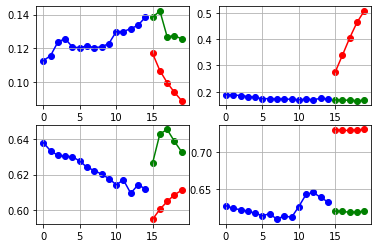

In [11]:
subplots = [221, 222, 223, 224]
plt.figure(1)
for plot_id, i in enumerate(np.random.choice(range(len(x_test)), size=4, replace=False)):
    p1 = np.expand_dims(predicts[i][:,0], axis=-1)
    x1 = np.expand_dims(x_test[i][:,0], axis=-1)
    y1 = np.expand_dims(y_test[i][:,0], axis=-1)
    ff, xx, yy = p1 * norm_constant, x1 * norm_constant, y1 * norm_constant
    plt.subplot(subplots[plot_id])
    plt.grid()
    plot_scatter(range(0, backcast_length), xx, color='b')
    plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, color='g')
    plot_scatter(range(backcast_length, backcast_length + forecast_length), ff, color='r')
plt.show()